
==== dn1.csv ====
Proposed ROIs (xmin, xmax):
    (np.float64(19393.0), np.float64(19993.0))
    (np.float64(21939.0), np.float64(22539.0))
    (np.float64(26205.0), np.float64(26805.0))
  Peak 1: centre = 19702.29 Â± 1.16 (sweep units)
  Peak 2: centre = 22227.24 Â± 1.31 (sweep units)
  Peak 3: centre = 26513.47 Â± 2.99 (sweep units)

==== dn2.csv ====
Proposed ROIs (xmin, xmax):
    (np.float64(14248.0), np.float64(14848.0))
    (np.float64(16782.0), np.float64(17382.0))
    (np.float64(18080.0), np.float64(18680.0))
    (np.float64(20516.0), np.float64(21116.0))
  Peak 1: centre = 14248.27 Â± 0.00 (sweep units)
  Peak 2: centre = 17064.59 Â± 1.02 (sweep units)
  Peak 3: centre = 18381.80 Â± 0.96 (sweep units)
  Peak 4: centre = 20820.64 Â± 1.79 (sweep units)

==== dn3.csv ====
Proposed ROIs (xmin, xmax):
    (np.float64(15057.0), np.float64(15657.0))
    (np.float64(16082.0), np.float64(16682.0))
  Peak 1: centre = 15288.21 Â± 3.05 (sweep units)
  Peak 2: centre = 16369.69 Â± 1.94 

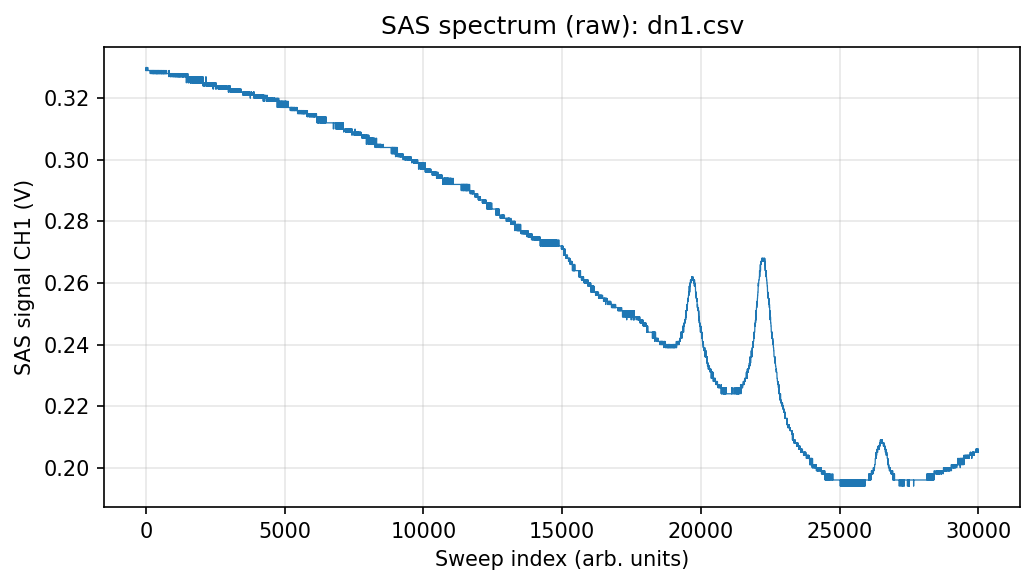

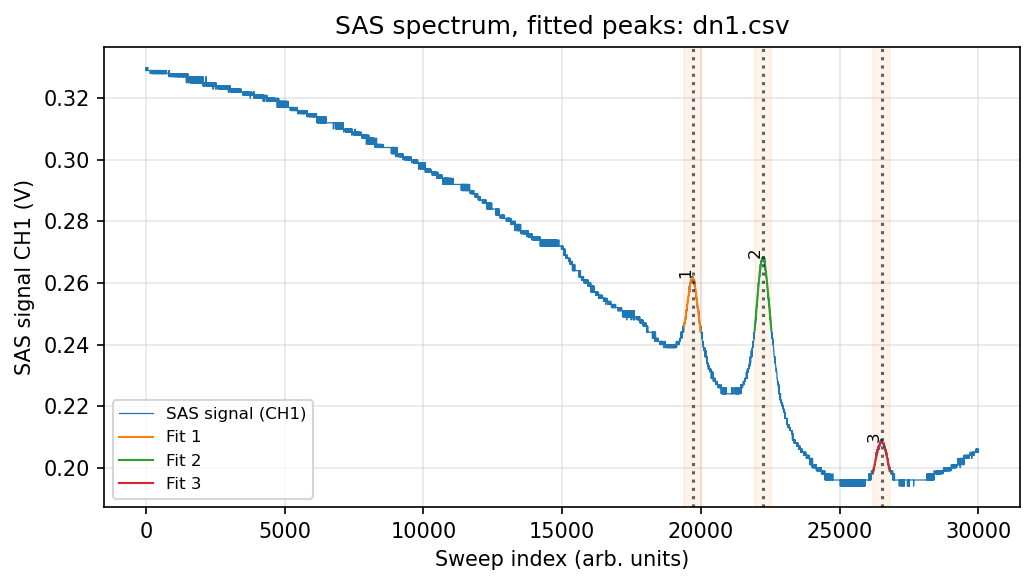

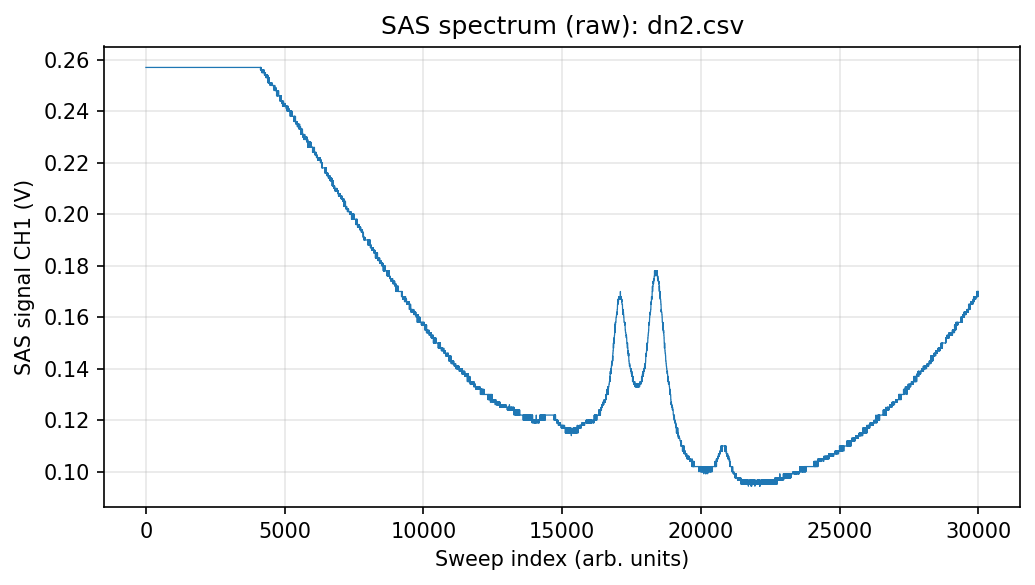

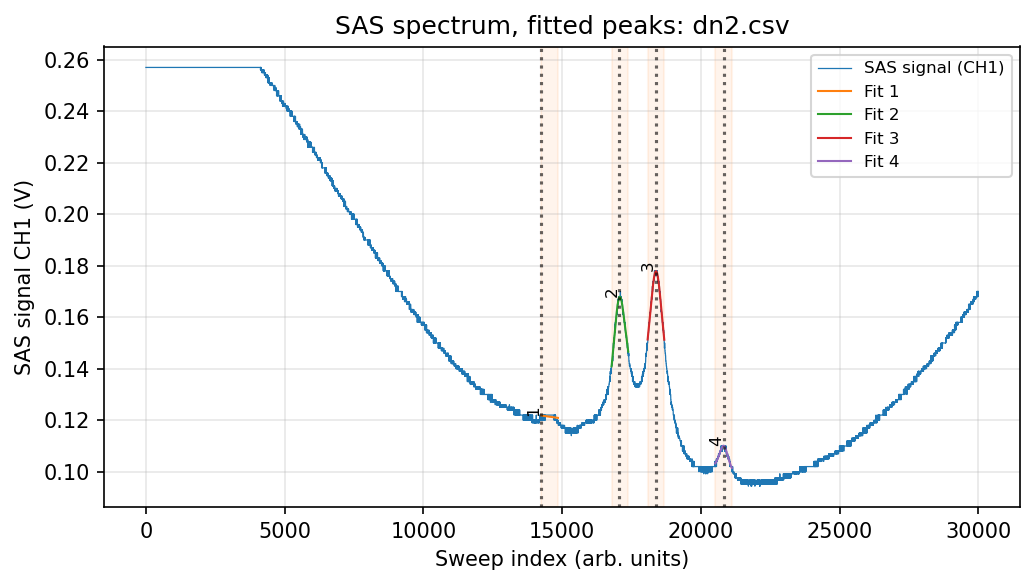

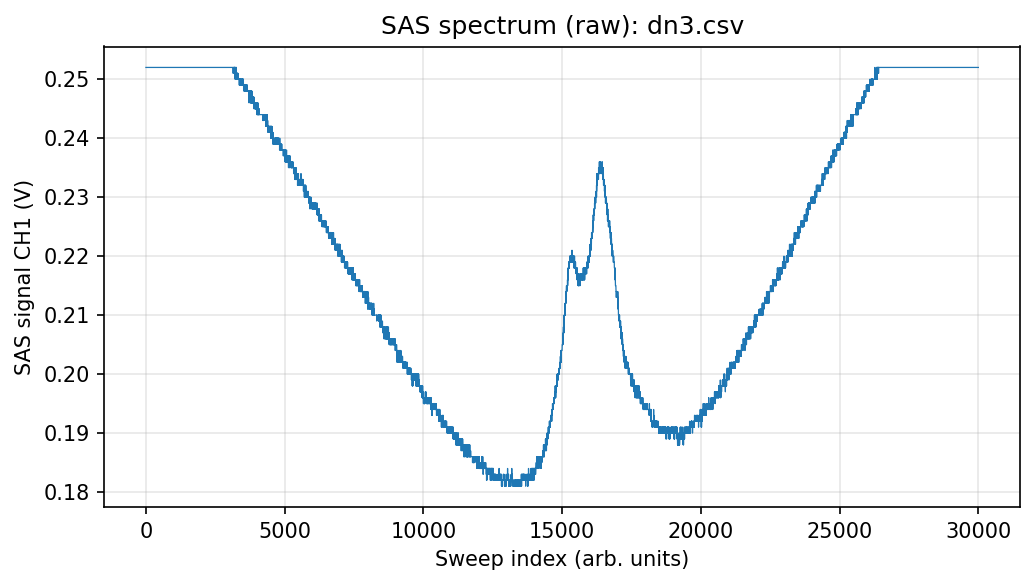

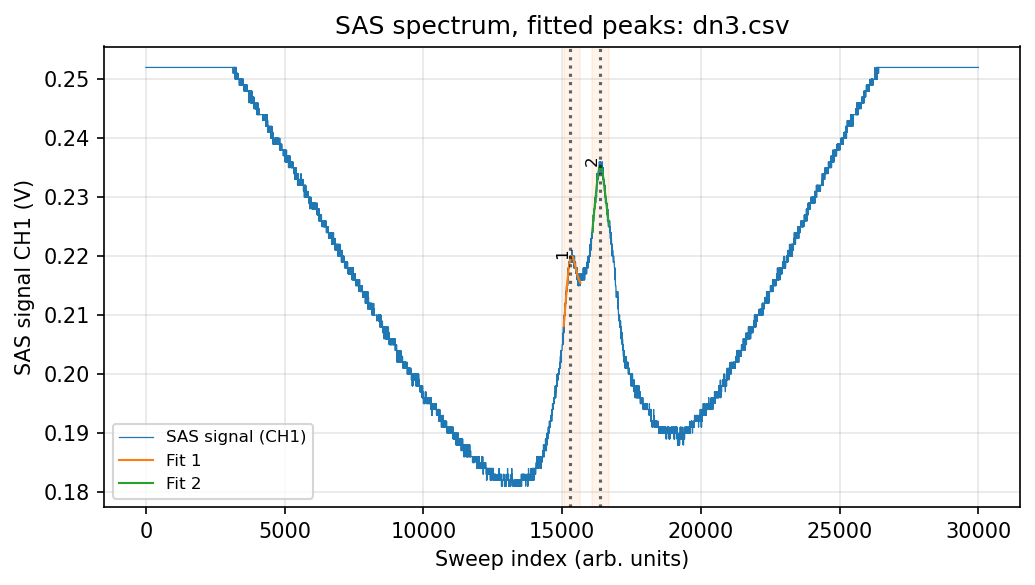

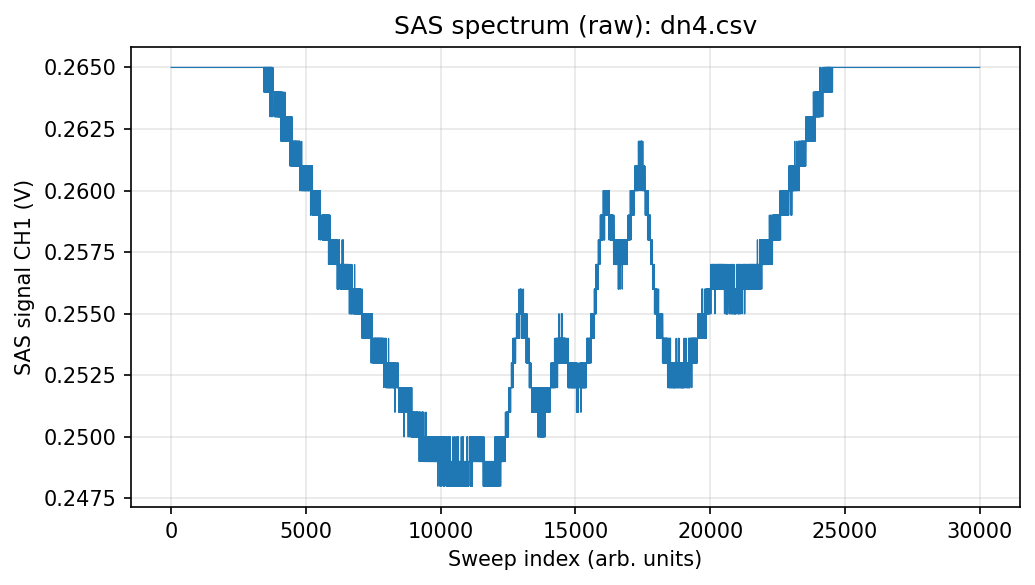

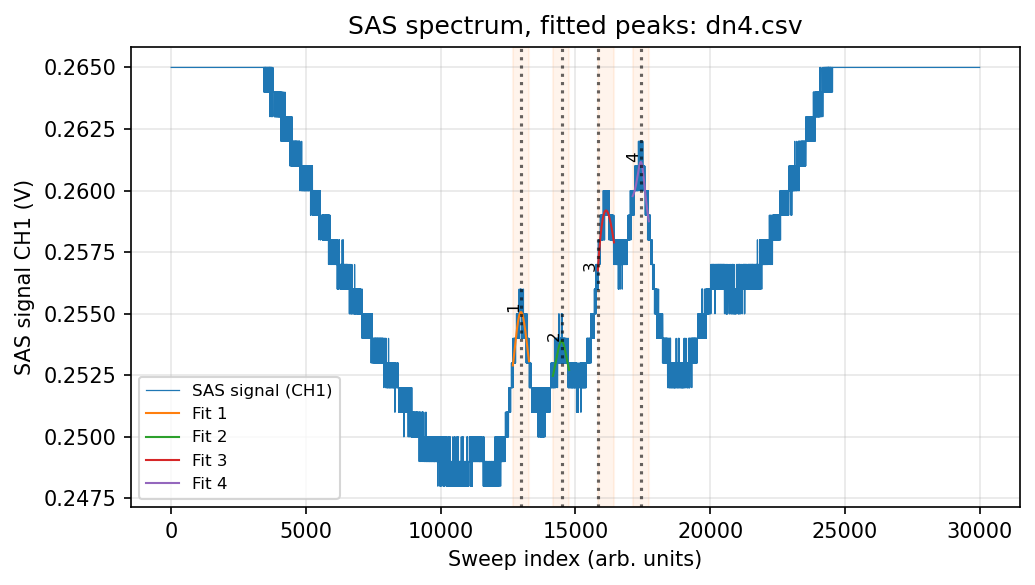

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

# -------------------------------------------------
# 1. Load Tektronix CSV, use CH1 as SAS signal
# -------------------------------------------------

def load_scope_csv(path, channel="CH1"):
    df = pd.read_csv(path)
    x = df["X"].iloc[1:].astype(float).values     # sweep axis
    y = df[channel].iloc[1:].astype(float).values
    return x, y


# -------------------------------------------------
# 2. Visualise at full resolution
# -------------------------------------------------

def plot_raw(path):
    x, y = load_scope_csv(path, channel="CH1")
    plt.figure(figsize=(7, 4), dpi=150)
    plt.plot(x, y, lw=0.6)
    plt.title(f"SAS spectrum (raw): {path}")
    plt.xlabel("Sweep index (arb. units)")
    plt.ylabel("SAS signal CH1 (V)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return x, y


# -------------------------------------------------
# 3. Propose ROIs around peaks (dips that go up)
# -------------------------------------------------

def propose_rois(x, y, n_features=6, roi_half_width=300,
                 sigma=40, prominence=0.001):
    """
    Find regions of interest around the strongest peaks
    (Lamb dips + crossovers). Returns a list of (xmin, xmax).
    """
    y_s = gaussian_filter1d(y, sigma=sigma)

    # Now we look for peaks, not valleys
    peaks, props = find_peaks(y_s, prominence=prominence)

    # Sort peaks by height (largest first) and keep n_features
    peaks_sorted = sorted(peaks, key=lambda p: y_s[p], reverse=True)
    peaks_use = peaks_sorted[:n_features]

    rois = []
    for p in peaks_use:
        xc = x[p]
        rois.append((xc - roi_half_width, xc + roi_half_width))

    # Sort ROIs by centre so that left-to-right is consistent
    rois.sort(key=lambda r: 0.5 * (r[0] + r[1]))
    return rois


# -------------------------------------------------
# 4. Lorentzian peak + linear background
# -------------------------------------------------

def lorentz_with_linear_bg(x, a0, a1, A, xc, gamma):
    """
    y(x) = a0 + a1 (x - xc)
           + A * gamma^2 / ((x - xc)^2 + gamma^2)

    For a peak above background, A > 0.
    """
    return a0 + a1 * (x - xc) + A * gamma**2 / ((x - xc)**2 + gamma**2)


def fit_lorentz_roi(x, y, xmin, xmax):
    mask = (x >= xmin) & (x <= xmax)
    xr = x[mask]
    yr = y[mask]

    if xr.size < 10:
        raise ValueError("ROI too small to fit")

    # Initial guesses: use local maximum for the peak
    xc_guess = xr[np.argmax(yr)]
    a0_guess = np.median(yr)
    a1_guess = 0.0
    A_guess = yr.max() - a0_guess          # positive peak height
    gamma_guess = 0.1 * (xmax - xmin)

    p0 = [a0_guess, a1_guess, A_guess, xc_guess, gamma_guess]
    bounds = (
        [-np.inf, -np.inf,       0.0, xmin, 0.0],   # A >= 0, gamma > 0
        [ np.inf,  np.inf,  np.inf, xmax, np.inf],
    )

    popt, pcov = curve_fit(
        lorentz_with_linear_bg, xr, yr,
        p0=p0, bounds=bounds, maxfev=20000
    )
    perr = np.sqrt(np.diag(pcov))
    return xr, yr, popt, perr


# -------------------------------------------------
# 5. Apply to dn1...dn4, plot with ROIs and centres
# -------------------------------------------------

files = ["dn1.csv", "dn2.csv", "dn3.csv", "dn4.csv"]
all_centres = {}

for fname in files:
    print("\n====", fname, "====")
    x, y = plot_raw(fname)  # full resolution plot

    rois = propose_rois(x, y, n_features=6)
    print("Proposed ROIs (xmin, xmax):")
    for r in rois:
        print("   ", r)

    centres = []
    fig, ax = plt.subplots(figsize=(7, 4), dpi=150)
    ax.plot(x, y, lw=0.6, label="SAS signal (CH1)")

    for i, (xmin, xmax) in enumerate(rois, start=1):
        xr, yr, popt, perr = fit_lorentz_roi(x, y, xmin, xmax)
        a0, a1, A, xc, gamma = popt
        centres.append(xc)

        # Plot the fitted peak
        x_fit = np.linspace(xmin, xmax, 400)
        y_fit = lorentz_with_linear_bg(x_fit, *popt)
        ax.plot(x_fit, y_fit, lw=1.0, label=f"Fit {i}")

        # Shade ROI and mark centre
        ax.axvspan(xmin, xmax, alpha=0.08, color="C1")
        ax.axvline(xc, color="k", linestyle=":", alpha=0.6)
        ax.text(xc, np.interp(xc, x_fit, y_fit),
                f"{i}", rotation=90,
                va="bottom", ha="right", fontsize=8)

        print(f"  Peak {i}: centre = {xc:.2f} Â± {perr[3]:.2f} (sweep units)")

    all_centres[fname] = np.array(centres)

    ax.set_xlabel("Sweep index (arb. units)")
    ax.set_ylabel("SAS signal CH1 (V)")
    ax.set_title(f"SAS spectrum, fitted peaks: {fname}")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best", fontsize=8)
    plt.tight_layout()

plt.show()


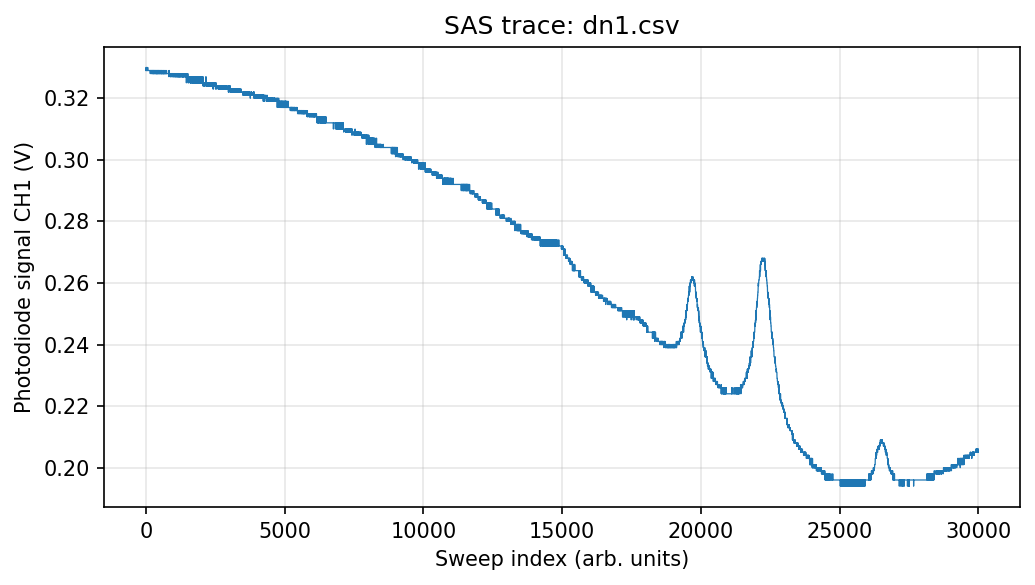

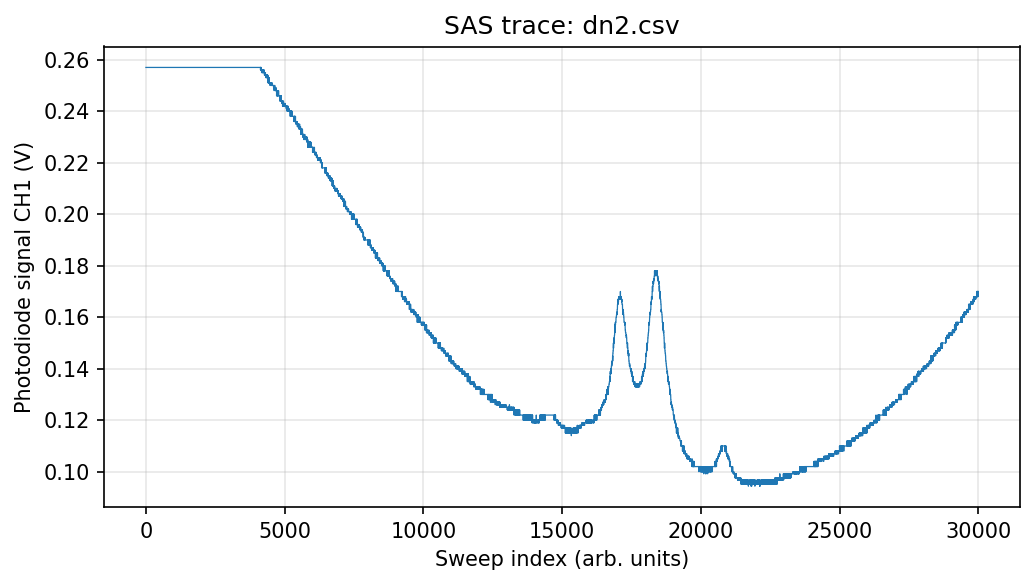

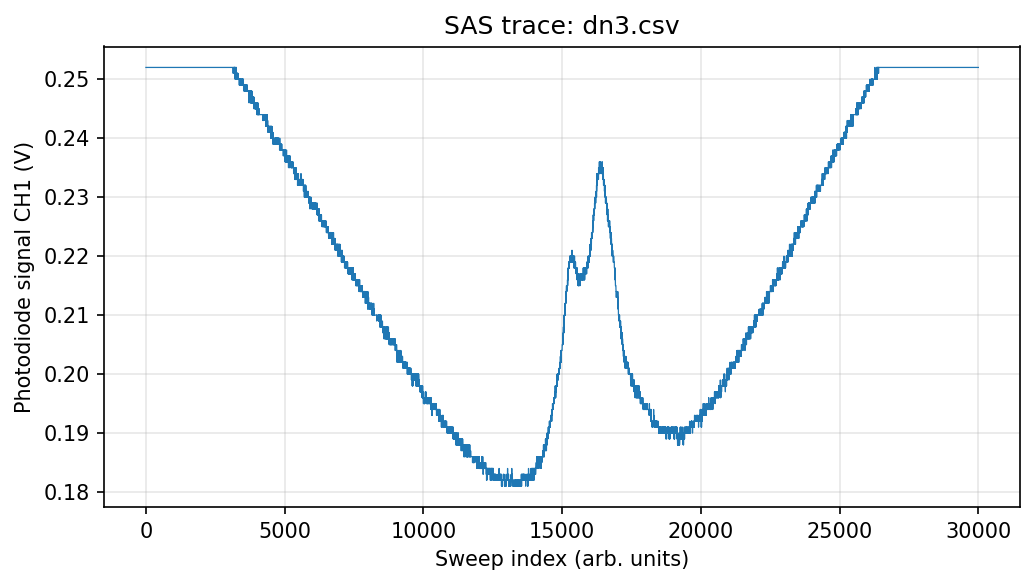

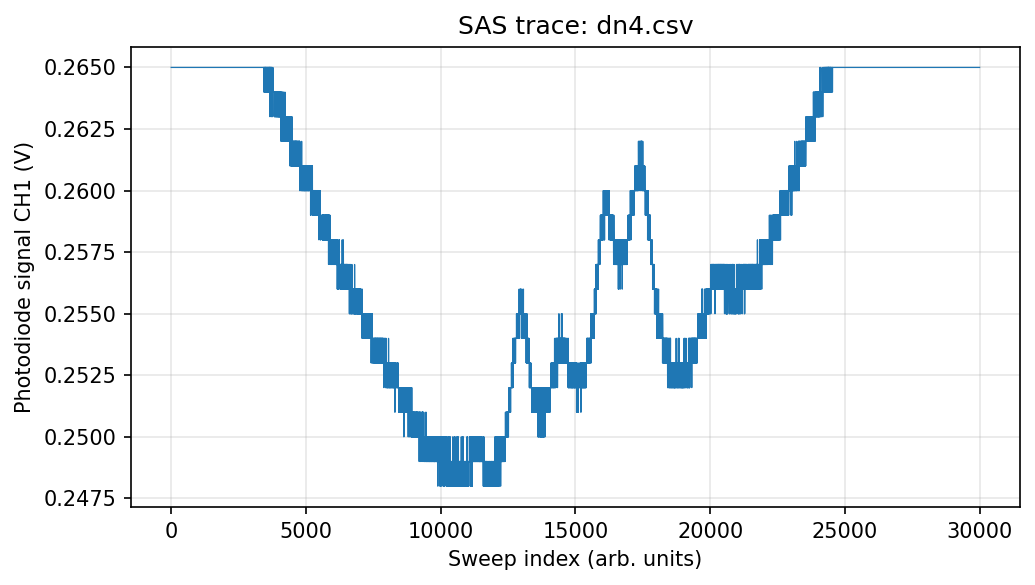

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# List of files to view
files = ["dn1.csv", "dn2.csv", "dn3.csv", "dn4.csv"]

for fname in files:
    # Tektronix-style CSV: first data row is labels ("Sequence", "Volt", ...)
    df = pd.read_csv(fname)

    # Sweep axis and SAS signal
    x = df["X"].iloc[1:].astype(float).values    # "Sequence" index
    y = df["CH1"].iloc[1:].astype(float).values  # SAS photodiode channel

    # Optional: if you want to see the gate as well, uncomment:
    # gate = df["CH4"].iloc[1:].astype(float).values

    plt.figure(figsize=(7, 4), dpi=150)
    plt.plot(x, y, linewidth=0.6)

    plt.title(f"SAS trace: {fname}")
    plt.xlabel("Sweep index (arb. units)")
    plt.ylabel("Photodiode signal CH1 (V)")
    plt.grid(True, alpha=0.3)

    # If you want to overlay the TTL gate on a second axis:
    # ax = plt.gca()
    # ax2 = ax.twinx()
    # ax2.plot(x, gate, linewidth=0.5, alpha=0.4)
    # ax2.set_ylabel("Gate CH4 (V)")

    plt.tight_layout()

plt.show()


## Rb-85 F=3 Lamb dips and crossovers (literature)
Ref: Steck Rb-85 D2. Frequencies are relative to F=3?F'4 (MHz).

LaTeX snippet for the report:

```
\\begin{tabular}{lll}
\\hline
Label & Transition & $\\nu$ (MHz rel. F{=}3\\,$\\to$\\,F'4)\\\\
\\hline
L1 & F=3$\\to$F'2 & $-120.64$\\\\
L2 & F=3$\\to$F'3 & $-63.43$\\\\
L3 & F=3$\\to$F'4 & $0$\\\\
X23 & C/O(F'2,3) & $-92.04$\\\\
X34 & C/O(F'3,4) & $-31.71$\\\\
X24 & C/O(F'2,4) & $-60.32$\\\\
\\hline
\\end{tabular}
```


In [ ]:
# Calibration for dn2 against literature Lamb dips / crossovers (Rb-85 F=3, D2)
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

lit = pd.DataFrame([
    ("L1", "F=3?F'2", -120.64),
    ("L2", "F=3?F'3",  -63.43),
    ("L3", "F=3?F'4",    0.00),
    ("X23","C/O(2,3)",  -92.04),
    ("X34","C/O(3,4)",  -31.71),
    ("X24","C/O(2,4)",  -60.32),
], columns=["label","transition","MHz"])

# --- user override to avoid bad automatic fits ---
manual_sweep_override = [14248.27, 17064.59, 18381.80, 20820.64]  # set [] to re-enable auto fitting
labels_order = ["L1", "X23", "L2", "X34"]
# -------------------------------------------------

def load_scope_csv_simple(path, channel="CH1"):
    df = pd.read_csv(path)
    x = df['X'].iloc[1:].astype(float).values
    y = df[channel].iloc[1:].astype(float).values
    return x, y

def fit_peaks(path, n_features=4, roi_half_width=300, sigma=30, prominence=5e-4):
    x, y = load_scope_csv_simple(path)
    y_s = gaussian_filter1d(y, sigma=sigma)
    peaks, _ = find_peaks(y_s, prominence=prominence)
    peaks = sorted(peaks, key=lambda p: y_s[p], reverse=True)[:n_features]
    rois = [(x[p]-roi_half_width, x[p]+roi_half_width) for p in peaks]
    rois.sort(key=lambda r: 0.5*(r[0]+r[1]))

    def lorentz_with_linear_bg(x, a0, a1, A, xc, gamma):
        return a0 + a1*(x - xc) + A*gamma**2 / ((x - xc)**2 + gamma**2)

    rows = []
    for xmin, xmax in rois:
        mask = (x >= xmin) & (x <= xmax)
        xr, yr = x[mask], y[mask]
        xc0 = xr[np.argmax(yr)]
        a0 = np.median(yr)
        A0 = yr.max() - a0
        g0 = 0.1*(xmax-xmin)
        p0 = [a0, 0, A0, xc0, g0]
        bounds = ([-np.inf, -np.inf, 0, xmin, 0], [np.inf, np.inf, np.inf, xmax, np.inf])
        popt, pcov = curve_fit(lorentz_with_linear_bg, xr, yr, p0=p0, bounds=bounds, maxfev=20000)
        perr = np.sqrt(np.diag(pcov))
        rows.append({"sweep": popt[3], "sweep_err": perr[3]})

    peaks_df = pd.DataFrame(rows).sort_values('sweep').reset_index(drop=True)
    return x, y, peaks_df

x_dn2, y_dn2 = load_scope_csv_simple('dn2.csv')
if manual_sweep_override:
    meas = pd.DataFrame({"sweep": manual_sweep_override})
    mode = "manual override"
else:
    x_dn2, y_dn2, meas = fit_peaks('dn2.csv')
    mode = "auto fit"

lit_sel = lit.set_index('label').loc[labels_order].reset_index()
A = np.vstack([meas['sweep'], np.ones(len(meas))]).T
slope, offset = np.linalg.lstsq(A, lit_sel['MHz'], rcond=None)[0]
meas['MHz_calibrated'] = slope*meas['sweep'] + offset
comparison = pd.concat([lit_sel, meas], axis=1)
comparison['delta_MHz'] = comparison['MHz_calibrated'] - comparison['MHz']

print(f"Mode: {mode}")
print(f"Calibration: MHz ? {slope:.8f} * sweep + {offset:.2f}")
display(lit)
display(comparison)


In [ ]:
# Annotated plot for dn2 using the literature markers
def plot_dn2_annotated():
    fig, ax = plt.subplots(figsize=(7,4), dpi=150)
    ax.plot(x_dn2, y_dn2, lw=0.6, label='dn2 CH1')
    for _, row in comparison.iterrows():
        sweep_expected = (row['MHz'] - offset)/slope
        ax.axvline(sweep_expected, color='k', ls=':', alpha=0.5)
        ax.text(sweep_expected, ax.get_ylim()[1]*0.9, row['label'], rotation=90,
                ha='right', va='top', fontsize=8)
    ax.set_xlabel('Sweep index (arb. units)')
    ax.set_ylabel('SAS signal CH1 (V)')
    ax.set_title('dn2 with literature markers (Rb-85 F=3)')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    plt.tight_layout()

plot_dn2_annotated()

# To label dn1/dn3/dn4 Doppler features: convert desired MHz to sweep via
#   sweep ? (MHz - offset) / slope
# and drop vertical lines at those sweep values.


Notes for other traces (dn1/dn3/dn4):

- Use the same slope/offset to map MHz?sweep.
- Rb-85 Doppler centers (relative to F=3?F'4): 0 (F'4), -63.43 (F'3), -120.64 (F'2), with crossovers near -92 and -31.7 MHz.
- If F=2 manifold is present: add +3035.732 MHz to those offsets (e.g., +2915.1, +2972.3, +3035.7 MHz for F=2?F'1/2/3).
- To annotate: compute sweep=(MHz-offset)/slope, then use ax.axvline + text labels on your plot.


## Manual peak selection + calibration (Rb-85 F=3 and Rb-87 F=2)
Use clearer peaks (dn1 Rb-87, dn3 Rb-85) to define sweep positions manually, fit a linear MHz calibration, and annotate any trace. Edit the parameters in the code cell below, run it, then run the plot.


In [ ]:
# Manual calibration with user-defined peaks
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# Literature frequencies (MHz) relative to cycling transition
lit_sets = {
    'Rb85_F3': pd.DataFrame([
        ("L1", "F=3?F'2", -120.64),
        ("L2", "F=3?F'3",  -63.43),
        ("L3", "F=3?F'4",    0.00),
        ("X23","C/O(2,3)",  -92.04),
        ("X34","C/O(3,4)",  -31.71),
        ("X24","C/O(2,4)",  -60.32),
    ], columns=["label","transition","MHz"]),
    'Rb87_F2': pd.DataFrame([
        ("L0", "F=2?F'0",  -503.54),
        ("L1", "F=2?F'1",  -424.95),
        ("L2", "F=2?F'2",  -266.65),
        ("L3", "F=2?F'3",     0.00),
        ("X12","C/O(1,2)",  -345.80),
        ("X23","C/O(2,3)",  -133.32),
        ("X13","C/O(1,3)",  -212.48),
        ("X02","C/O(0,2)",  -385.10),
    ], columns=["label","transition","MHz"]),
}

# --- user inputs ---
file_to_use = 'dn1.csv'        # choose dn1/dn2/dn3/dn4
lit_choice = 'Rb87_F2'         # 'Rb87_F2' or 'Rb85_F3'
manual_sweep = [14548.0, 17079.0, 18380.0, 20816.0]  # example sweep positions you pick
labels_use   = ['L2', 'X23', 'L3', 'X34']             # same length, in the same order as manual_sweep
zero_label   = 'L3'               # label to set as 0 MHz in plotting (e.g., largest peak)
# -------------------

# Helper to load Tektronix CSV
def load_scope_csv_simple(path, channel="CH1"):
    df = pd.read_csv(path)
    x = df['X'].iloc[1:].astype(float).values
    y = df[channel].iloc[1:].astype(float).values
    return x, y

lit = lit_sets[lit_choice].set_index('label')
if len(manual_sweep) != len(labels_use):
    raise ValueError("manual_sweep and labels_use must have same length")

lit_sel = lit.loc[labels_use].reset_index()
A = np.vstack([manual_sweep, np.ones(len(manual_sweep))]).T
slope, offset = np.linalg.lstsq(A, lit_sel['MHz'], rcond=None)[0]
freq_manual = slope*np.array(manual_sweep) + offset
comparison = lit_sel.assign(sweep=manual_sweep, MHz_calibrated=freq_manual)
comparison['delta_MHz'] = comparison['MHz_calibrated'] - comparison['MHz']
zero_shift = lit.loc[zero_label, 'MHz']
comparison['MHz_centered'] = comparison['MHz_calibrated'] - zero_shift

print(f"Calibration ({lit_choice}): MHz ? {slope:.8f} * sweep + {offset:.2f}")
print(f"Zeroed at {zero_label} (shift {zero_shift:+.2f} MHz)")

display(lit_sets[lit_choice])
display(comparison)

# Plot with manual markers
x, y = load_scope_csv_simple(file_to_use)
fig, ax = plt.subplots(figsize=(7,4), dpi=150)
ax.plot(x, y, lw=0.6, label=file_to_use)
for _, row in comparison.iterrows():
    ax.axvline(row['sweep'], color='k', ls=':', alpha=0.5)
    ax.text(row['sweep'], ax.get_ylim()[1]*0.9,
            f"{row['label']}\n{row['MHz_centered']:+.1f} MHz",
            rotation=90, ha='right', va='top', fontsize=8)
ax.set_xlabel('Sweep index (arb. units)')
ax.set_ylabel('SAS signal CH1 (V)')
ax.set_title(f"{file_to_use} manual calibration ({lit_choice})")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)
plt.tight_layout()
